In [27]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from keras import models, layers
from skimage import feature
from sklearn.metrics import classification_report

Leemos las imagenes de una carpeta con cv2 y os las guardamos en un numpy array

In [3]:
import cv2

def resize_and_pad(img, size, pad_color=0):
    h, w = img.shape[:2]
    sh, sw = size

    # Interpolación a usar
    interp = cv2.INTER_AREA if h > sh and w > sw else cv2.INTER_CUBIC

    # Relación de aspecto de la imagen
    aspect = w/h  

    # Cálculo de las dimensiones, manteniendo la relación de aspecto
    if aspect > 1:
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1:
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else:
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # Escalar y rellenar
    img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    img = cv2.copyMakeBorder(img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=pad_color)

    return img


def read_images(folder_path,color=cv2.COLOR_RGB2BGR, resize=True, size=(260, 260)):
    images = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg', '.png')):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                if resize:
                    image = resize_and_pad(image, size)

                image = cv2.cvtColor(image, color)
                images.append(image)
    return images
t = time.time() 
images = read_images("../backend/fileRecognition/1604259")
print("Time: ", time.time() - t)
images = np.array(images)
images.shape


Time:  0.1646120548248291


(49, 260, 260, 3)

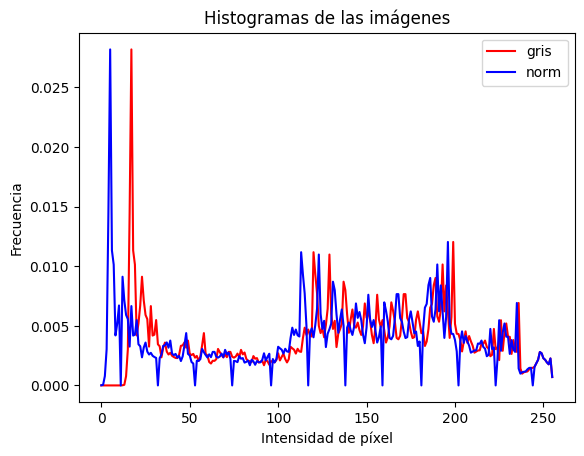

In [4]:
imagen_bgr = cv2.imread('./fileRecognition/albert/frame_1.jpg')

imagen_gris = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2GRAY)


imagen_gris_norm = cv2.normalize(imagen_gris, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)


histograma_gris = cv2.calcHist([imagen_gris], [0], None, [256], [0, 256])
histograma_gris_norm = cv2.calcHist([imagen_gris_norm], [0], None, [256], [0, 256])

histograma_gris_norm /= histograma_gris_norm.sum()
histograma_gris /= histograma_gris.sum()



# Visualizar los histogramas (opcional)
plt.plot(histograma_gris, color='r')
plt.plot(histograma_gris_norm, color='b')
plt.title('Histogramas de las imágenes')
plt.xlabel('Intensidad de píxel')
plt.ylabel('Frecuencia')
plt.legend(['gris', 'norm'])
plt.show()



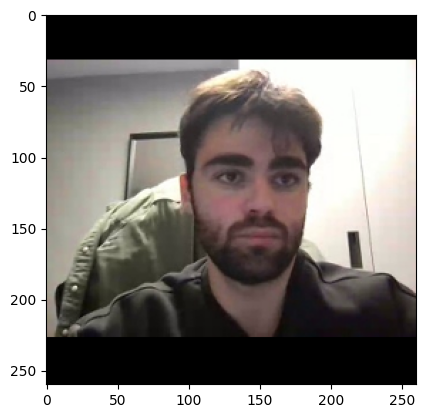

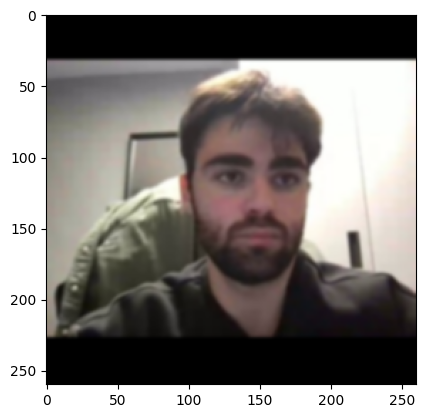

In [5]:
smoothed_image = cv2.GaussianBlur(images[5], (5, 5), 0)
image = cv2.cvtColor(images[5], cv2.COLOR_RGB2BGR)


plt.imshow(images[5])
plt.show()
plt.imshow(smoothed_image)
plt.show()

In [6]:
import dlib

detector = dlib.get_frontal_face_detector()



In [7]:
images_persons = read_images("../backend/fileRecognition/trainFaces")


images_persons = np.array(images_persons)
images_persons.shape


(289, 260, 260, 3)

(240, 320)
[[ 0.  5.  7. ...  9.  8.  7.]
 [ 4.  4.  3. ... 10.  9.  8.]
 [ 4.  4.  3. ... 11. 10.  7.]
 ...
 [ 9. 10. 11. ... 12. 25.  5.]
 [ 8.  9. 10. ... 11. 25.  5.]
 [ 7.  8.  9. ...  9. 25.  3.]]


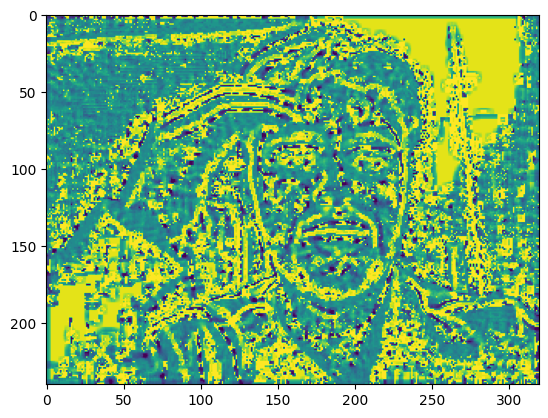

In [8]:

# Cargar la imagen
imagen = cv2.imread('../backend/fileRecognition/1604259/frame_15.jpg', cv2.IMREAD_GRAYSCALE)

# Calcular el LBP
radius = 3
n_points = 8 * radius
lbp = feature.local_binary_pattern(imagen, n_points, radius, method='uniform')


print(imagen.shape)
print(lbp) 

plt.imshow(lbp)
plt.show()



In [9]:
# Definir el modelo de red neuronal
neuronal_network = Sequential([
    layers.Dense(32, input_shape=(10,), activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Capa de salida con activación sigmoid para clasificación binaria
])

neuronal_network.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [10]:
from sklearn.linear_model import LogisticRegression


In [24]:
class LSPModel:
        # Definir el modelo de red neuronal

    
    def __init__(self, radius=3, n_points=8, method='uniform', modelo='nn'):
        self.radius = radius
        self.n_points = n_points
        self.method = method
        self.lbp_array = []
        nn = models.Sequential([
            layers.Dense(32, input_shape=(10,), activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(1, activation='sigmoid')  # Capa de salida con activación sigmoid para clasificación binaria
        ])

        # Compilar el modelo
        nn.compile(optimizer='rmsprop',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
        
        self.neuronal_network = nn
        self.histograma = []
        self.model = modelo
    def fit(self, X, y):
        false_images = read_images("../backend/fileRecognition/trainFaces", color=cv2.COLOR_BGR2GRAY)
        false_images = np.array(false_images)


        X_train = np.concatenate([X, false_images[:len(X)]])
        y_train = np.concatenate([np.ones(len(X)), np.zeros(len(X))])
 
        self.lbp_array = []
        self.histograma = []
        for image in X_train:
            image = image.astype('uint8')
            lbp = feature.local_binary_pattern(image, self.n_points, self.radius)
            self.lbp_array.append(lbp)
            hist, _ = np.histogram(lbp, bins=np.arange(0, self.n_points + 3), range=(0, self.n_points + 2))
            hist = hist.astype("float")
            # Normalizar el histograma
            hist /= (hist.sum() + 1e-7)
            self.histograma.append(hist)
        self.lbp_array = np.array(self.lbp_array)
        self.histograma = np.array(self.histograma)
        print(self.histograma.shape, y_train.shape)
        
        if self.model == 'nn':
            neuronal_network.fit(self.histograma, y_train, epochs=400)
        elif self.model == 'lr':
            m = LogisticRegression()
            m.fit(self.histograma, y_train)
        
        
    
    def predict(self, X):
        lbp_array = []
        hist = []
        for image in X:
            image = image.astype('uint8')
            lbp = feature.local_binary_pattern(image, self.n_points, self.radius)
            lbp_array.append(lbp)
            histograma, _ = np.histogram(lbp, bins=np.arange(0, self.n_points + 3), range=(0, self.n_points + 2))
            histograma = histograma.astype("float")
            # Normalizar el histograma
            histograma /= (histograma.sum() + 1e-7)
            hist.append(histograma)
        lbp_array = np.array(lbp_array)
        hist = np.array(hist)
        print(hist.shape)
        return self.neuronal_network.predict(hist)
    
    def store_model(self, path):
        self.neuronal_network.save(path)
    def load_model(self, path):
        self.neuronal_network = models.load_model(path)

  

 

In [16]:
true_images = read_images("../backend/fileRecognition/1604259", color=cv2.COLOR_BGR2GRAY)
true_images = np.array(true_images)
false_images = read_images("../backend/fileRecognition/trainFaces", color=cv2.COLOR_BGR2GRAY)
false_images = np.array(false_images)


X_train = true_images
y_train = np.ones(len(true_images))


validation = read_images("../backend/fileRecognition/albert", color=cv2.COLOR_BGR2GRAY)
validation = np.array(validation)

X_validation = np.concatenate([validation, false_images[len(true_images):]])

y_validation = np.concatenate([np.array(np.ones(len(validation))), np.array(np.zeros(len(false_images[len(true_images):])))])

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((49, 260, 260), (49,), (291, 260, 260), (291,))

In [29]:
model = LSPModel(modelo='nn')

model.fit(X_train, y_train)


(98, 10) (98,)
Epoch 1/400
4/4 [==============================] - 0s 2ms/step - loss: 0.0902 - accuracy: 0.9796
Epoch 2/400
4/4 [==============================] - 0s 2ms/step - loss: 0.0883 - accuracy: 0.9796
Epoch 3/400
4/4 [==============================] - 0s 2ms/step - loss: 0.0874 - accuracy: 0.9796
Epoch 4/400
4/4 [==============================] - 0s 2ms/step - loss: 0.0904 - accuracy: 0.9796
Epoch 5/400
4/4 [==============================] - 0s 2ms/step - loss: 0.0872 - accuracy: 0.9796
Epoch 6/400
4/4 [==============================] - 0s 2ms/step - loss: 0.0873 - accuracy: 0.9796
Epoch 7/400
4/4 [==============================] - 0s 2ms/step - loss: 0.0879 - accuracy: 0.9796
Epoch 8/400
4/4 [==============================] - 0s 2ms/step - loss: 0.0868 - accuracy: 0.9796
Epoch 9/400
4/4 [==============================] - 0s 2ms/step - loss: 0.0868 - accuracy: 0.9796
Epoch 10/400
4/4 [==============================] - 0s 2ms/step - loss: 0.0853 - accuracy: 0.9796
Epoch 11/400
4

In [30]:
y_validation_pred = model.predict(X_validation)

y_validation_pred = y_validation_pred > 0.5

from sklearn.metrics import classification_report
print (classification_report(y_validation, y_validation_pred))

(289, 10)
10/10 [==============================] - 0s 901us/step
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91       240
         1.0       0.61      0.22      0.33        49

    accuracy                           0.84       289
   macro avg       0.74      0.60      0.62       289
weighted avg       0.82      0.84      0.81       289



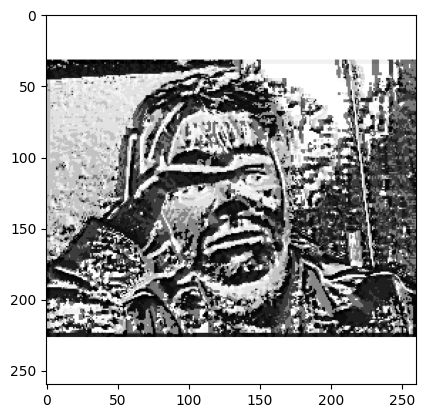

In [17]:
plt.imshow(model.lbp_array[0],cmap='gray')

In [20]:
hist, _ = np.histogram(model.lbp_array.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
hist = hist.astype("float")

# Normalizar el histograma
hist /= (hist.sum() + 1e-7)



print("Histograma LBP:")
print(hist)

Histograma LBP:
[0.18987959 0.05771838 0.02593867 0.03466324 0.06358663 0.0129998
 0.03921268 0.09023149 0.02634998 0.00587913 0.00412399 0.00477795
 0.04154997 0.00801185 0.06492066 0.13776069 0.05053677 0.03865338
 0.007137   0.00675071 0.01443504 0.00780293 0.00835787 0.01200091
 0.03533678 0.01138394]


In [44]:
false_images = read_images("../backend/fileRecognition/trainFaces", color=cv2.COLOR_BGR2GRAY)
false_images = np.array(false_images)

validation = read_images("../backend/fileRecognition/a", color=cv2.COLOR_BGR2GRAY)
validation = np.array(validation)



X_validation = np.concatenate([validation, false_images[len(validation):]])

y_validation = np.concatenate([np.array(np.ones(len(validation))), np.array(np.zeros(len(false_images[len(validation):])))])

model = LSPModel()
model.load_model("./fileRecognition/albert/model.h5")
y_pred = model.predict(X_validation)

(289, 10)
10/10 [==============================] - 0s 1ms/step


In [45]:

y_pred = y_pred > 0.5
print(classification_report(y_pred, y_validation))

              precision    recall  f1-score   support

       False       0.98      0.82      0.89       284
        True       0.00      0.00      0.00         5

    accuracy                           0.81       289
   macro avg       0.49      0.41      0.45       289
weighted avg       0.96      0.81      0.88       289

